## SVM en Python

Vamos a construir un modelo de Machine Learning que pueda identificar si un correo electrónico es spam o no, por lo que este es un problema de clasificación binaria:

#### Paso 1. Lectura del conjunto de datos

In [1]:
import pandas as pd

total_data = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/machine-learning-content/master/assets/spam.csv")
total_data.head()

Category                                            Message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...

#### Paso 2: Procesamiento de datos

##### Transformación categórica a numérica

Transformamos nuestras dos categorías `spam` y `ham` en valores numéricos (`0` y `1`), ya que este, como la mayoría de los modelos, no trabajan con variables de clase categóricas:

In [2]:
total_data["Category"] = total_data["Category"].apply(lambda x: 1 if x == "spam" else 0).astype(int)
total_data.head()

Category                                            Message
0         0  Go until jurong point, crazy.. Available only ...
1         0                      Ok lar... Joking wif u oni...
2         1  Free entry in 2 a wkly comp to win FA Cup fina...
3         0  U dun say so early hor... U c already then say...
4         0  Nah I don't think he goes to usf, he lives aro...

##### Eliminación de valores repetidos

Podemos contar fácilmente cuántos casos de cada clase tenemos para analizar si el conjunto de datos está equilibrado o no:

In [3]:
print(total_data.shape)
print(f"Spam: {len(total_data.loc[total_data.Category == 1])}")
print(f"No spam: {len(total_data.loc[total_data.Category == 0])}")

(5572, 2)
Spam: 747
No spam: 4825


Debemos eliminar también los duplicados, si los hubiera:

In [4]:
total_data = total_data.drop_duplicates()
total_data = total_data.reset_index(inplace = False, drop = True)
total_data.shape

(5157, 2)

En este caso vemos que se han eliminado más de 400 registros repetidos.

##### Procesamiento del texto

Para poder entrenar el modelo es necesario aplicar antes un proceso de transformación al texto. Comenzamos transformando el texto a minúsculas y eliminando signos de puntuación y caracteres especiales:

In [5]:
import regex as re

def preprocess_text(text):
    # Eliminar cualquier caracter que no sea una letra (a-z) o un espacio en blanco ( )
    text = re.sub(r'[^a-z ]', " ", text)
    
    # Eliminar espacios en blanco
    text = re.sub(r'\s+[a-zA-Z]\s+', " ", text)
    text = re.sub(r'\^[a-zA-Z]\s+', " ", text)

    # Reducir espacios en blanco múltiples a uno único
    text = re.sub(r'\s+', " ", text.lower())

    # Eliminar tags
    text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)

    return text.split()

total_data["Message"] = total_data["Message"].apply(preprocess_text)
total_data.head()

Category                                            Message
0         0  [until, jurong, point, crazy, vailable, only, ...
1         0                             [lar, oking, wif, oni]
2         1  [ree, entry, in, wkly, comp, to, win, up, fina...
3         0     [dun, say, so, early, hor, already, then, say]
4         0  [ah, don, think, he, goes, to, usf, he, lives,...

El siguiente paso es la **lematización del texto**, que es el proceso de simplificación de las palabras a su forma base o canónica, de manera que palabras con diferentes formas, pero el mismo núcleo semántico, se traten como una sola palabra. Por ejemplo, los verbos "corriendo", "corrió" y "corre" serán lematizados a "correr", así como las palabras "mejores" y "mejor" podrían ser lematizadas a "bueno".

Además, aprovechando la lematización, eliminaremos también las **stopwords**, que son palabras que consideramos irrelevantes para el análisis de texto porque aparece con mucha frecuencia en el lenguaje y no aporta información significativa. Existen dos formas: crear nosotros nuestra propia lista de palabras a eliminar o utilizar librerías externas. 

Ambas tareas las llevaremos a cabo con la librería de Python `NLTK`, que es una de las más importantes en términos del NLP:

In [6]:
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
download("wordnet")
lemmatizer = WordNetLemmatizer()

download("stopwords")
stop_words = stopwords.words("english")

def lemmatize_text(words, lemmatizer = lemmatizer):
    tokens = [lemmatizer.lemmatize(word) for word in words]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if len(word) > 3]
    return tokens

total_data["Message"] = total_data["Message"].apply(lemmatize_text)
total_data.head()

[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Category                                            Message
0         0  [jurong, point, crazy, vailable, bugis, great,...
1         0                                            [oking]
2         1  [entry, wkly, comp, final, tkts, receive, entr...
3         0                                   [early, already]
4         0                      [think, life, around, though]

Algo muy común una vez tenemos los tokens es representarlos en una **nube de palabras**. Una nube de palabras es una representación visual de las palabras que componen un texto, donde el tamaño de cada palabra indica su frecuencia o importancia en dicho texto.

Esta representación visual permite identificar rápidamente los términos o conceptos más relevantes o repetidos en un conjunto de datos, ya que las palabras más frecuentes o significativas sobresalen por su tamaño. Podemos implementarla fácilmente utilizando la librería `wordcloud` para Python:

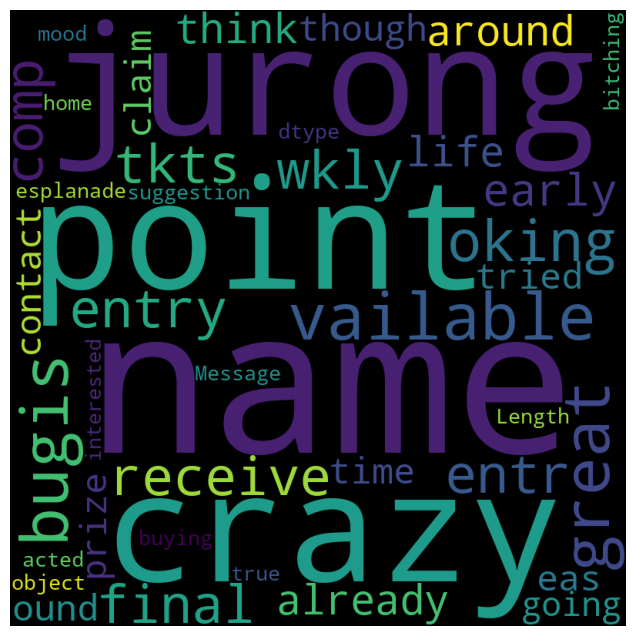

In [7]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(width = 800, height = 800, background_color = "black", max_words = 1000, min_font_size = 20, random_state = 42)\
    .generate(str(total_data["Message"]))

fig = plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

El último paso antes de entrenar el modelo es convertirlo en números, ya que los modelos no pueden entrenar con categorías textuales. En módulos anteriores vimos cómo podíamos transformar el texto en vectores numéricos utilizando el `CountVectorizer` de `scikit-learn`, pero aquí aplicaremos un proceso nuevo para brindar más herramientas al estudiante:

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

tokens_list = total_data["Message"]
tokens_list = [" ".join(tokens) for tokens in tokens_list]

vectorizer = TfidfVectorizer(max_features = 5000, max_df = 0.8, min_df = 5)
X = vectorizer.fit_transform(tokens_list).toarray()
y = total_data["Category"]

X[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

`TfidfVectorizer` convierte una colección de documentos de texto brutos en una matriz de características de TF-IDF. TF-IDF es una medida que cuantifica la importancia de una palabra en un documento en relación con un corpus. Se compone de dos términos:

- **TF** (*Term Frequency*): Es la frecuencia de una palabra en un documento.
- **IDF** (*Inverse Document Frequency*): Mide la importancia del término en el corpus. Un término que aparece en muchos documentos puede no ser tan informativo.

Por lo tanto, al usar `TfidfVectorizer`, transformamos una colección de documentos de texto en una matriz numérica que representa la importancia relativa de cada palabra en cada documento, en relación con el corpus entero. Esta matriz es comúnmente utilizada como entrada para algoritmos de aprendizaje automático, especialmente en tareas de procesamiento de lenguaje natural como clasificación de texto.

##### División en conjuntos de entrenamiento y prueba

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

#### Paso 3: Inicialización y entrenamiento del modelo

In [10]:
from sklearn.svm import SVC

model = SVC(kernel = "linear", random_state = 42)
model.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

#### Paso 4: Predicción del modelo

Una vez se ha entrenado el modelo, se puede utilizar para predecir con el conjunto de datos de prueba (*test*).

In [11]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

Con los datos en crudo es muy complicado saber si el modelo está acertando o no. Para ello, debemos compararlo con la realidad. Existe una gran cantidad de métricas para medir la efectividad de un modelo a la hora de predecir, entre ellas la **precisión** (*accuracy*), que es la fracción de predicciones que el modelo realizó correctamente.

In [12]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.9748062015503876

#### Paso 5: Guardado del modelo

Una vez tenemos el modelo que estábamos buscando (presumiblemente tras la optimización de hiperparámetros), para poder utilizarlo a futuro es necesario almacenarlo en nuestro directorio, junto a la semilla.

In [13]:
from pickle import dump

dump(model, open("svm_classifier_linear_42.sav", "wb"))

Añadir un nombre explicativo al modelo es vital, ya que en el caso de perder el código que lo ha generado sabremos, por un lado, qué configuración tiene (en este caso ponemos `linear` porque el kernel es lineal) y además la semilla para replicar los componentes aleatorios del modelo, que en este caso lo hacemos añadiendo un número al nombre del archivo, el `42`.